In [1]:
import json
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import datetime as dt

mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 40})

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Analyzing Rent Prices vs. Taxi Trips

In [323]:
# taxi id - zillow id mapping
tz_map = json.load(open('./taxi_zillow_mapping.json'))

# Group zillow and taxi data according to composite ID.
taxi_to_cluster = {}
zillow_to_cluster = {}
cid_to_cluster = {}
for cluster in tz_map:
    cid_to_cluster[cluster['id']] = cluster
    for t in cluster['taxi_ids']:
        assert t not in taxi_to_cluster
        taxi_to_cluster[t] = cluster['id']
    for z in cluster['zillow_ids']:
        assert z not in zillow_to_cluster
        zillow_to_cluster[z] = cluster['id']
        
tz_map[4:6]

[{u'id': 5,
  u'name': u'Prospect Park',
  u'taxi_ids': [190],
  u'zillow_ids': [403161]},
 {u'id': 6,
  u'name': u'Brownsville',
  u'taxi_ids': [35],
  u'zillow_ids': [193526]}]

In [154]:
from datetime import date

In [365]:
def get_taxis(weekend_only=False,
              day_normalized=True,
              add_green=True,
              event='DO',
              plot_settings={},
              min_trips=0,
              max_trips=1e100,
              min_year=2013,
              min_month=1,
              plot=False):
    # Load the yellow taxi analysis
    yellow = pd.read_csv('yellow_daily.csv', index_col=None, header=None)
    green = pd.read_csv('green_daily.csv', index_col=None, header=None)
    yellow.columns = ['location_id', 'event', 'year', 'month', 'day',
                     'passengers', 'distance', 'fare', 'count']
    green.columns = yellow.columns[:]
    
    if add_green:
        combined = pd.concat([yellow, green], axis=0, ignore_index=True)
        combined = combined.groupby(['location_id', 'event', 'year', 'month', 'day'])\
            .sum().reset_index()
        yellow = combined

    is_weekend = []
    SATURDAY = 5
    for y in yellow.itertuples():
        d = date(y.year, y.month, y.day)
        is_weekend.append(d.weekday() >= SATURDAY)
        
    if weekend_only:
        yellow = yellow[is_weekend]

    # What are daily stats for the entire city?
    yellow_citywide = yellow.drop(['location_id'], axis=1)\
        .groupby(by=['event', 'year', 'month', 'day'])\
        .sum().reset_index()
    yellow_citywide = yellow_citywide[yellow_citywide['year'] >= 2013]
    cw = yellow_citywide
    cw = cw[cw['event'] == event]
    cw = cw[cw['year'] < 2017]
    cw = cw[cw['year'] >= min_year]
    cw = cw[['year', 'month', 'day', 'count']]
    cw_mean = cw['count'].mean()
    print(len(cw))

    yellow['composite_id'] = yellow['location_id'].map(lambda x: taxi_to_cluster.get(x, -1))
    
    yellow_composite = yellow.drop('location_id', axis=1)\
        .groupby(by=['composite_id', 'event', 'year', 'month', 'day'])\
        .sum().reset_index()
        
    available_cluster_ids = list(yellow['composite_id'].unique())
    by_cluster_map = {}
    counts = []
    for cluster_id in available_cluster_ids:
        # Get taxi dropoffs
        yc = yellow_composite
        taxis = yc[yc['composite_id'] == cluster_id]
        taxis = taxis[taxis['event'] == event]
        taxis = taxis[taxis['year'] < 2017]
        taxis = taxis[taxis['year'] >= min_year]
        taxis = taxis[(taxis['year'] > min_year) | (taxis['month'] >= min_month)]
        taxis = taxis[['year', 'month', 'day', 'count']]
        sum_count = taxis['count'].sum()
        counts.append(sum_count)
        taxis = pd.merge(taxis, cw, on=['year', 'month', 'day'])
        
        if day_normalized:
            cy = taxis['count_y']
            taxis['count'] = taxis['count_x'].as_matrix() * cw_mean / cy.as_matrix()
        else:
            taxis['count'] = taxis['count_x']
        taxis = taxis[['year', 'month', 'day', 'count']]
            
        taxis = taxis[['year', 'month', 'count']]
        taxis = taxis.groupby(by=['year', 'month']).mean().reset_index()
        
        if sum_count < min_trips or sum_count > max_trips:
            continue

        by_cluster_map[cluster_id] = taxis
    
    if plot:
        plt.figure()
        plt.hist(np.log10(np.array(counts)), **plot_settings)
        plt.ylabel('log(trips)')
        plt.show()
        
    return yellow_composite, by_cluster_map

In [366]:
yellow = get_taxis(add_green=False)
combined = get_taxis()
combined_no_norm = get_taxis(day_normalized=False)
combined_min = get_taxis(min_trips=1e4)
combined_min_max = get_taxis(min_trips=1e4, max_trips=1e7)
combined_min_max_pu = get_taxis(min_trips=1e4, max_trips=1e7, event='PU')

1461
1461
1461
1461
1461
1461


In [367]:
yellow[1][112]

,year,month,count
0,2013,1,247.471221
1,2013,2,244.121439
2,2013,3,263.757292
3,2013,4,257.361432
4,2013,5,267.881324
5,2013,6,257.432143
6,2013,7,254.560677
7,2013,8,268.388467
8,2013,9,250.562304
9,2013,10,250.178156


# Adjust Zillow Rent Prices With Inflation

In [368]:
def get_zillow(fname='./Neighborhood_MedianRentalPrice_1Bedroom.csv',
              adjust_inflation=True):
    # Load zillow rent prices
    # DL from: http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_1Bedroom.csv
    zillow = pd.read_csv(fname)
    z = zillow
    zillow = zillow[(z['City'] == 'New York') & (z['State'] == 'NY')]
    early_cols = ['{}-{:02}'.format(year, month) for year in [2010, 2011, 2012, 2017] for month in range(1,13)]
    early_cols = [c for c in early_cols if c in zillow.columns]
    zillow = zillow.drop(early_cols, axis=1)

    # Read inflation data
    inflation = pd.read_csv('cpi_inflation.csv', index_col='Year')
    
    # Create an array with zillow prices adjusted by inflation.
    zillow_inf_adjust = zillow.copy()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    standard = inflation.ix[2016]['Dec'] # Rescale values to this time.
    for year in range(2013, 2017):
        for month in range(1, 13):
            colname = '{}-{:02}'.format(year, month)
            col = zillow_inf_adjust[colname]
            col = standard / inflation.ix[year][months[month - 1]] * col
            zillow_inf_adjust[colname] = col
            
    if not adjust_inflation:
        zillow_inf_adjust = zillow # Revert
    
    # What is the Zillow Neighborhood ID?
    zillow_shape = json.load(open('ZillowNeighborhoods-NY_mapshaper.json'))
    # Need a mapping from zillow region name to zillow ID
    z_name_to_id = {}
    for z in zillow_shape['features']:
        prop = z['properties']
        zid = int(prop['RegionID'])
        z_name_to_id[prop['Name']] = prop['RegionID']

    region_ids = []
    for z in zillow_inf_adjust.itertuples():
        regid = z_name_to_id[z.RegionName]
        region_ids.append(regid)
#        print(z.RegionName, regid)
    zillow_inf_adjust['RegionId'] = region_ids
        
    zillow_inf_adjust['CompositeId'] =\
        zillow_inf_adjust['RegionId'].map(lambda x: zillow_to_cluster.get(int(x), -1))
        
    z = zillow_inf_adjust
    zillow_composite = z.drop([
            'RegionName', 'City',
            'State', 'Metro', 'CountyName',
            'SizeRank', 'RegionId'], axis=1)\
        .groupby(by=['CompositeId'])\
        .mean().reset_index()
        
    zillow_t = zillow_composite.set_index('CompositeId').T
    by_cluster = {}
    for cluster_id in list(zillow_t.columns):
        col = zillow_t[cluster_id]
        pairs = zip(col.index, col)
        rows = []
        for date, price in pairs:
            year = int(date[:4])
            month = int(date[-2:])
            rows.append((year, month, price))
        df = pd.DataFrame(rows, columns=['year', 'month', 'price'])
        by_cluster[cluster_id] = df
        
    return zillow_composite, by_cluster

In [244]:
zillow_composite = get_zillow()
zillow_no_inflation = get_zillow(adjust_inflation=False)

In [245]:
zillow_composite[1][22]

,year,month,price
0,2013,1,1320.266596
1,2013,2,1372.083126
2,2013,3,1343.682474
3,2013,4,1367.687542
4,2013,5,1412.542652
5,2013,6,1416.006686
6,2013,7,1414.606579
7,2013,8,1412.409339
8,2013,9,1404.302825
9,2013,10,1408.287834


# Generate Plots

In [302]:
# What neighborhoods are available?
avail_ids = set(zillow_composite[1].keys()).intersection(set(combined[1].keys()))
for c in tz_map:
    if c['id'] in avail_ids:
        print(c['name'])

Central Park
Greenpoint
Park Slope
Bayside-Douglaston-Oakland Gardens
East Village
East Elmhurst-Jackson Heights
Long Island City/Hunters Point
East Flatbush
Kew Gardens-Richmond Hill
Kingsbridge Heights-University Heights/Morris Heights
East Harlem
Flatlands-Midwood
Cobble Hill
Bay Ridge
Concourse
Forest Hills-Forest Park/Highland Park-Glendale
Hamilton Heights-Manhattanville
Pelham Bay-Schuylerville/Edgewater Park
Boerum Hill-Carroll Gardens-Gowanus
TriBeCa/Civic Center
Brooklyn Heights
Inwood
Chinatown-Lower East Side
Elmhurst
Crown Heights
Harlem
Fort Greene
Washington Heights
Briarwood/Jamaica Hills
Midtown
East New York
Norwood
Windsor Terrace
Bronxdale-Co-Op City-Eastchester-Williamsbridge/Olinville
Woodside
Bushwick
Jamaica
Rego Park
Borough Park-Ocean Parkway South
Sunset Park-Greenwood
Erasmus-Flatbush/Ditmas Park
Flushing-Murray Hill-Auburndale
Clinton Hill-Bedford Stuyvesant
Pelham Parkway-Van Nest/Morris Park
Kew Gardens Hills
Prospect Heights
Garment District-Flatiron Dis

In [361]:
def single_location(name,
                    zillow_composite,
                    combined,
                    line_title,
                    taxi_line_title,
                    scatter_title):
    # find cluster matching that name.
    cluster = None
    for c in tz_map:
        if name.lower() in c['name'].lower():
            cluster = c
            break
    print(cluster)
    name = cluster['name']

    cid = cluster['id']
    # Get taxi data
    taxi = combined[1][cid]
    zillow = zillow_composite[1][cid]
    join = pd.merge(taxi, zillow, on=['year', 'month'])
    join = join.set_index(['year', 'month'])
    # Get one of the areas' columns

    plt.figure()
    ax = join['price'].plot(ax=plt.gca(), title=line_title, legend=False)
    plt.ylabel('Rent ($)')
    #ax = taxis.plot(ax=plt.gca(), legend=False)
    plt.show()

    plt.figure()
    ax = join['count'].plot(ax=plt.gca(), title=taxi_line_title, legend=False)
    plt.ylabel('Trips')
    #ax = taxis.plot(ax=plt.gca(), legend=False)
    plt.show()

    plt.figure()
    plt.scatter(join['count'], join['price'])
    plt.title(scatter_title)
    plt.show()
    print(join['count'].corr(join['price']))

    return join

{u'zillow_ids': [199001], u'id': 124, u'name': u'Williamsburg', u'taxi_ids': [80, 217, 255, 256]}


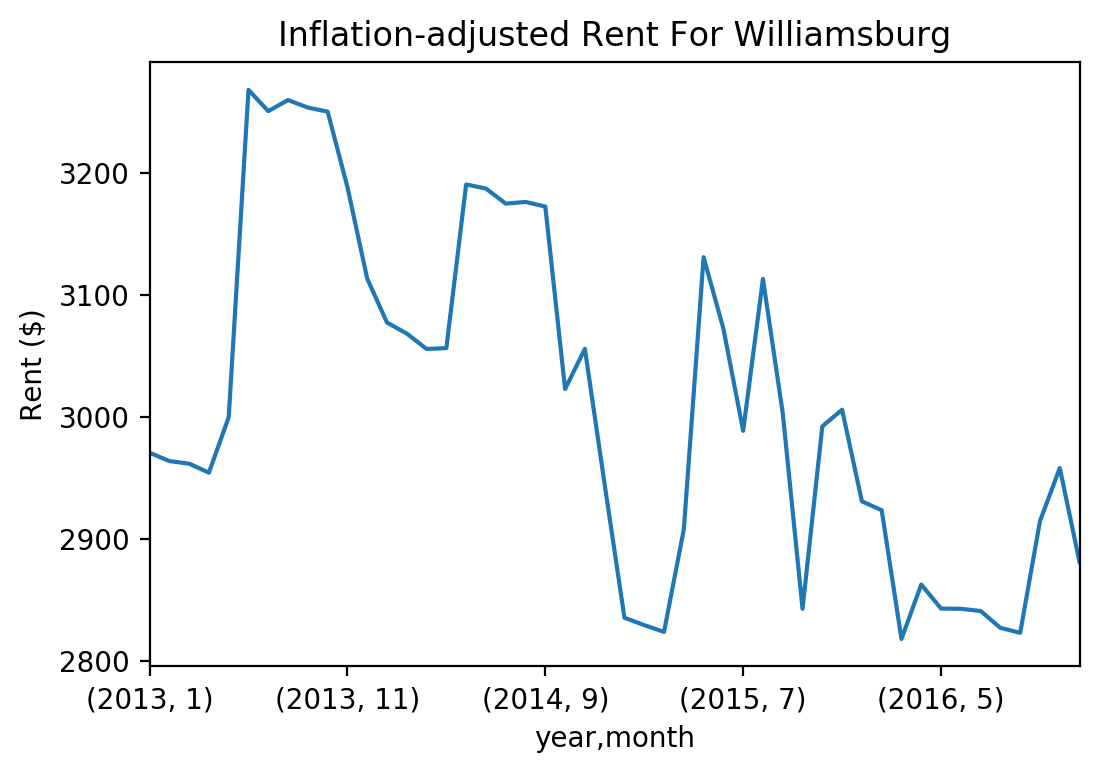

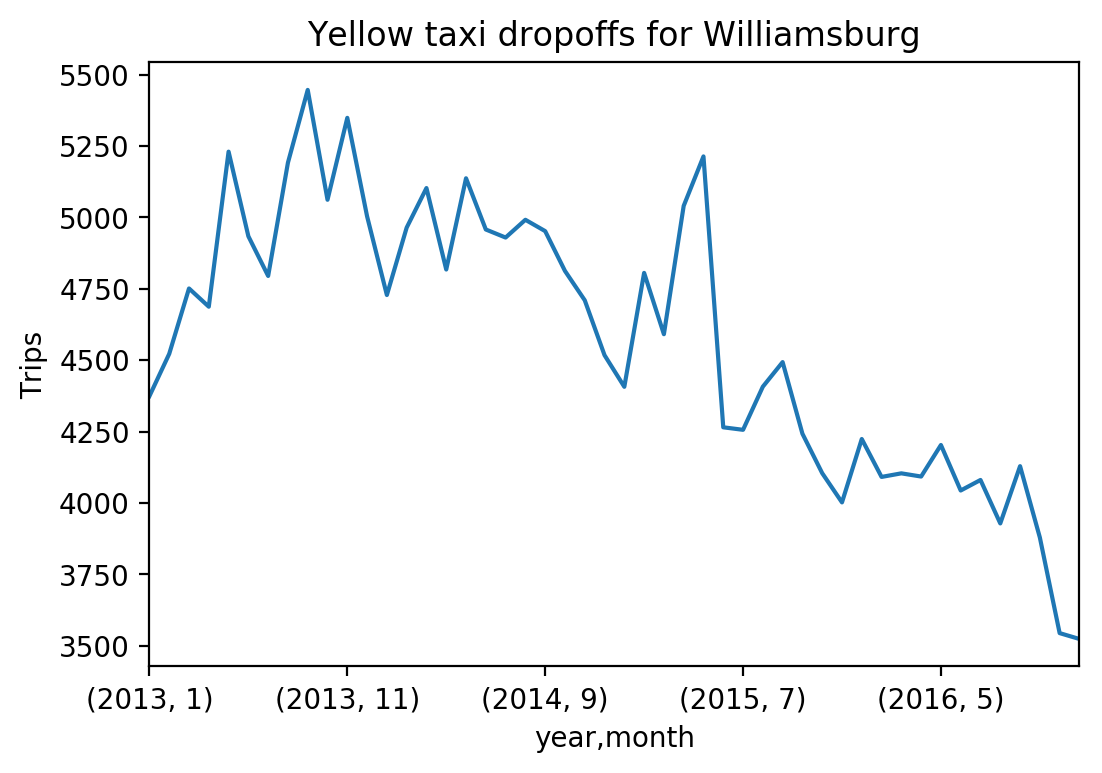

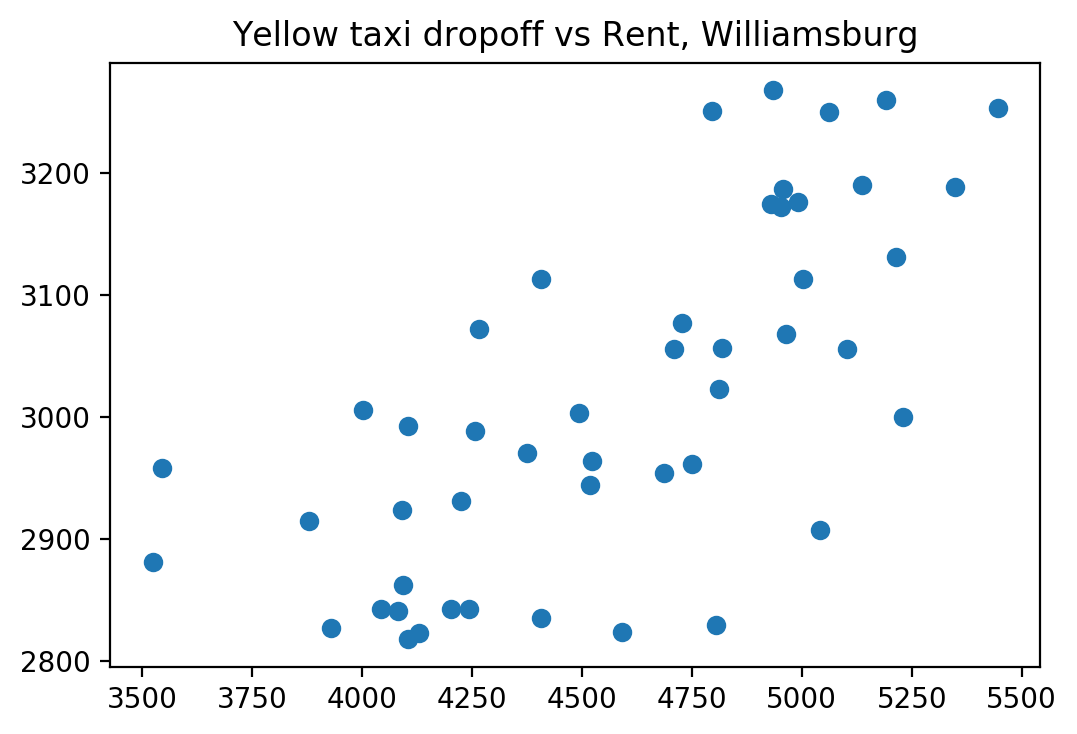

0.698700328063


count        price
year month                          
2013 1      4374.297761  2970.599840
     2      4522.265413  2963.699553
     3      4751.292345  2961.585860
     4      4687.458570  2954.205091
     5      5230.351619  2999.607949
     6      4934.161411  3267.707738
     7      4795.094841  3250.330654
     8      5191.825270  3259.406166
     9      5446.630750  3253.211178
     10     5061.908846  3249.895002
     11     5348.696759  3188.142458
     12     5003.815203  3113.181399
2014 1      4728.293872  3077.142597
     2      4964.274135  3068.136869
     3      5102.880140  3055.512478
     4      4817.576489  3056.249888
     5      5137.170913  3190.256346
     6      4957.788367  3186.930482
     7      4929.595693  3174.564103
     8      4991.808991  3175.934912
     9      4952.077647  3172.164645
     10     4812.700667  3022.693354
     11     4709.936764  3055.634798
     12     4517.591340  2944.604512
2015 1      4406.907113  2835.405932
     2      4805.845237  2829.358217
     3      4591.009506  2823.784873
     4      5040.434205  2907.651273
     5      5213.769483  3130.615083
     6      4265.089093  3072.184651
     7      4256.285736  2988.497641
     8      4407.327035  3112.904645
     9      4493.402250  3002.874551
     10     4242.783213  2842.774542
     11     4104.507021  2992.163808
     12     4002.162845  3005.771347
2016 1      4224.072605  2930.741144
     2      4091.316446  2923.451096
     3      4103.866535  2817.998601
     4      4092.659112  2862.589079
     5      4203.103309  2842.927165
     6      4043.775305  2842.723908
     7      4080.637355  2840.936209
     8      3928.468709  2827.105439
     9      4129.044918  2823.041186
     10     3879.156164  2914.548259
     11     3544.377274  2957.991796
     12     3523.786206  2881.000000

In [373]:
single_location('Williamsburg', zillow_composite, yellow,
                'Inflation-adjusted Rent For Williamsburg',
                'Yellow taxi dropoffs for Williamsburg',
                'Yellow taxi dropoff vs Rent, Williamsburg')

# Statistical Tests

Null hypothesis:
1. Taxi dropoffs at a certain location and rent aren't correlated.
1. Within each region, correlation should be random due to noise.
1. That means on average, half of the regions will have positive correlation, and half will have negative correlation, because we're just trying to find signal from random noise.
1. Rent-Taxi correlations between neighborhoods are independent of each other (admittedly a big assumption)

So if the null hypothesis holds, the direction of the correlations should be a fair coin flip ($p = 0.5$). We'll evaluate the correlation directions of each regions, and see if the result is likely under the null hypothesis.

In [369]:
from scipy.stats import norm

def evaluate(zillow_composite, yellow, title):
    # What neighborhoods are available?
    avail_ids = set(zillow_composite[1].keys()).intersection(set(yellow[1].keys()))
    corr = {}
    for cid in avail_ids:
        # Get taxi data
        taxi = yellow[1][cid]
        zillow = zillow_composite[1][cid]
        join = pd.merge(taxi, zillow, on=['year', 'month'])
        join = join.set_index(['year', 'month'])
        corr_cid = join['count'].corr(join['price'])
        if cid >= 0:
            corr[cid] = corr_cid
    
    corrs = sorted(list(corr.iteritems()), key=lambda x: abs(x[1]), reverse=True)
    for cid, c in corrs[:50]: # Top N most correlated/anticorrelated
        name = cid_to_cluster[cid]['name']
        print(name, c)

    corr = pd.Series(corr)

    plt.figure()
    corr.hist(ax=plt.gca())
    plt.title(title)
    plt.ylabel('Num. of regions')
    plt.xlabel('Correlation')
    plt.axvline(x=0.0, color='red')
    plt.show()

    # Statistical test.
    n = len(corr)
    print('N:', n)
    print('P:', )
    # 1 means "positive direction" and 0 means "negative direction".
    # Under H_0, the test statistic should be 0.5 * len(corr)
    t = sum(1 - np.signbit(corr.as_matrix())) # signbit -> positive -> False
    t = max(t, n - t) # Either positive or negative
    z = (t - n / 2.0) / np.sqrt(n * 0.5 * 0.5)

    # Normal approximation
    p = norm.sf(z) + norm.cdf(-z)

    print('alph:', 1.96)
    print('z:', z)
    print('p:', p)

Erasmus-Flatbush/Ditmas Park 0.805239510647
Bronxdale-Co-Op City-Eastchester-Williamsbridge/Olinville 0.798211818823
Kingsbridge Heights-University Heights/Morris Heights 0.78095417269
Harlem 0.741081831089
Kew Gardens-Richmond Hill 0.735025374554
Parkchester 0.706888772759
Williamsburg 0.698700328063
East New York 0.6830752499
Concourse 0.677598876982
Bedford Park-Spuyten Duyvil/Kingsbridge-Van Cortlandt Village 0.671892523216
Pelham Parkway-Van Nest/Morris Park 0.665138282611
Norwood 0.646088542365
Mount Hope 0.642646702263
Greenwich Village-NoHo-West Village 0.639798245888
Elmhurst 0.638556169859
East Flatbush 0.634520047409
Flatlands-Midwood 0.612373649399
Jamaica 0.611229815455
Crown Heights 0.584849856512
Flushing-Murray Hill-Auburndale 0.58461536905
East Harlem 0.566273017292
Washington Heights 0.494162835218
Boerum Hill-Carroll Gardens-Gowanus 0.481406774136
Pelham Bay-Schuylerville/Edgewater Park 0.455204597857
Windsor Terrace 0.444688550107
Clinton Hill-Bedford Stuyvesant 0.4

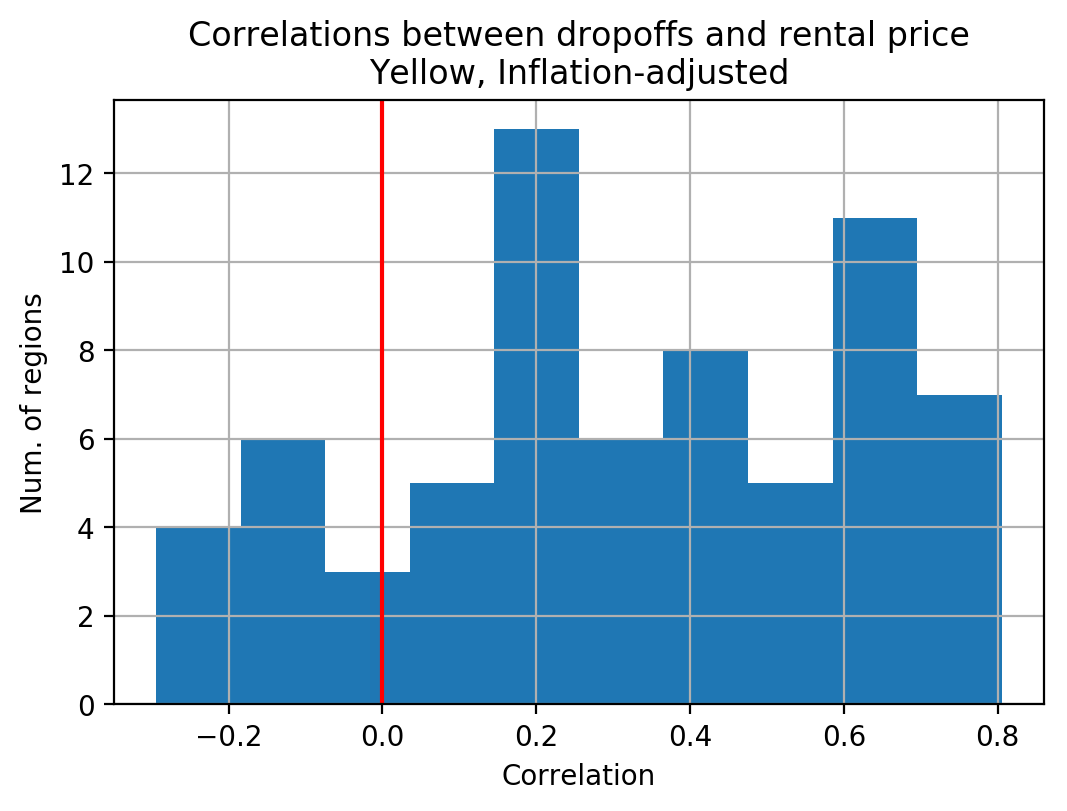

N: 68
alph: 1.96
z: 5.09324812576
p: 3.51980560064e-07


In [374]:
evaluate(zillow_composite, yellow,
        'Correlations between dropoffs and rental price\n'
              'Yellow, Inflation-adjusted')

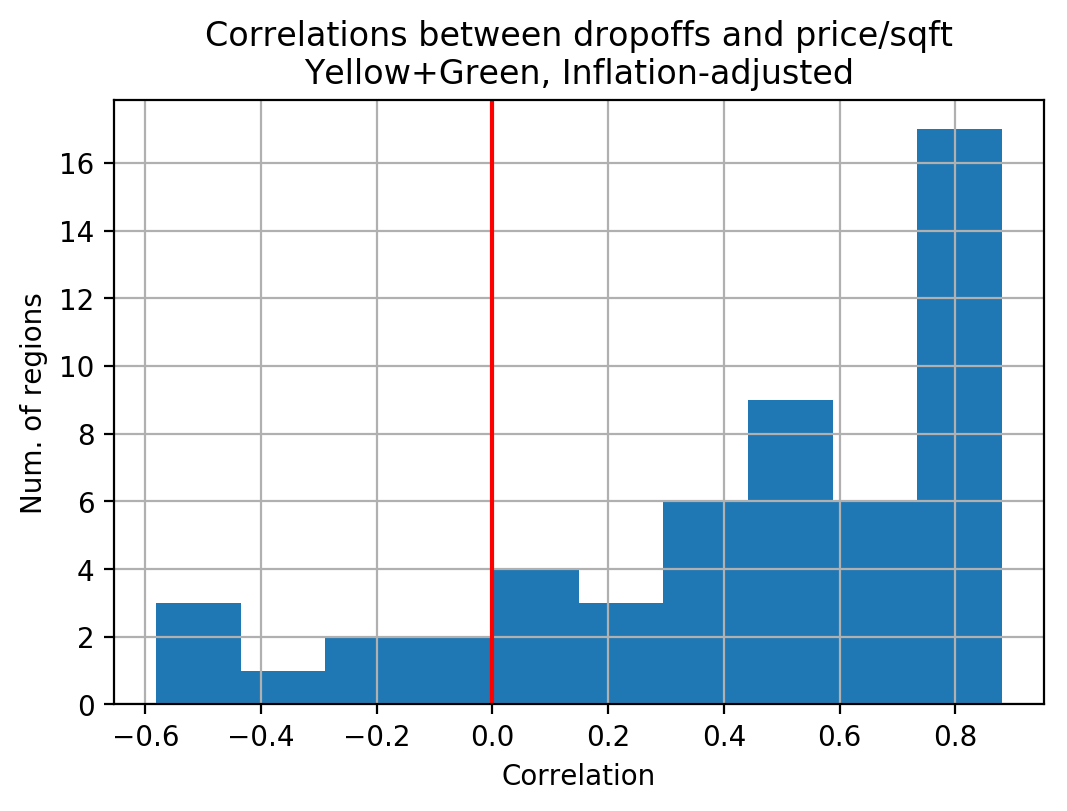

N: 53
alph: 1.96
z: 5.0823408661
p: 3.72811611586e-07


In [322]:
evaluate(zillow_composite, combined_min_max,
        'Correlations between dropoffs and price/sqft\n'
              'Yellow+Green, Inflation-adjusted')

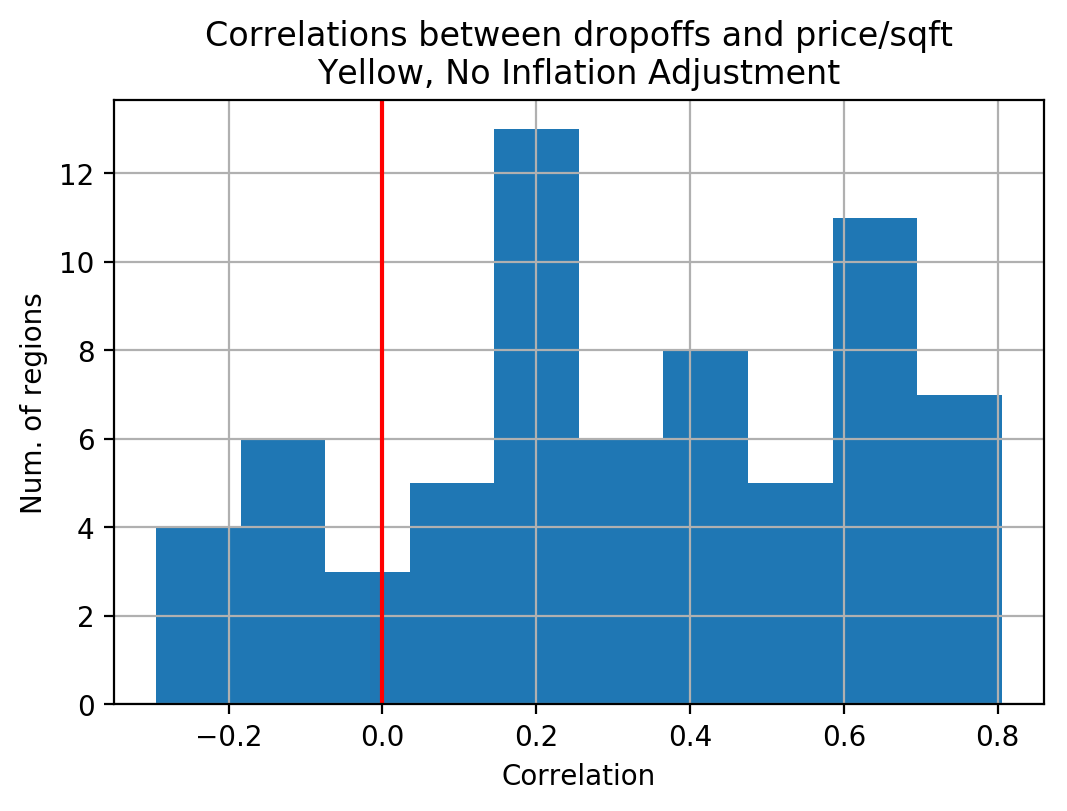

N: 68
alph: 1.96
z: 5.09324812576
p: 3.51980560064e-07


In [319]:
evaluate(zillow_composite, yellow,
        'Correlations between dropoffs and price/sqft\n'
              'Yellow, No Inflation Adjustment')